In [9]:
#importando bibliotecas 
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [10]:
#lendo os dados. não consegui estabelecer conexoes desse dataset, que era o que continha a variavel resposta, com os demais. 
# Um deles continha informacoes sobre o usuario, mas não encontrei a chave que o ligava aos demais. Por isso, usei apenas esse
#dataset. 
dados_1 = pd.read_csv('C:/Users/PC/Documents/educacao/challenge_stone/processed_labeled_transactions.csv')

In [11]:
#aqui interpretei que os na's se tratavam de propostas nao fraudulentas
dados_1.is_fraud = dados_1.is_fraud.fillna('False')

In [12]:
#recategorizando a variavel resposta
dados_1['is_fraud'].replace({True: 1, 'False': 0},inplace= True)

In [13]:
#verificando quantidade de fraudes
dados_1['is_fraud'].value_counts()

0    939400
1      1535
Name: is_fraud, dtype: int64

In [14]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [15]:
#criando um profile do dataset
profile = ProfileReport(dados_1, title="Pandas Profiling Report")

In [16]:
profile.to_file("C:/Users/PC/Documents/educacao/challenge_stone/report_stone.html")

In [ ]:
dados_1.columns

In [17]:
#eliminando na's
dados_1.dropna(inplace= True)

In [18]:
#definindo features. 
X = dados_1.drop(['operation_id','request_id','account_id','device_id','counterparty_document',
             'requested_at','processed_at','is_fraud'], axis = 1)

In [19]:
y = dados_1['is_fraud']

In [20]:
#categorizando as variaveis usando one hot enconding
X2 = X.copy()
cats = []
for col in X2.columns:
    if X2[col].dtype == object:
        X2 = X2.join(pd.get_dummies(X2[col], prefix=col), how='left')
        X2.drop(col, axis=1, inplace=True)


print('Dims', X2.shape)
X2.fillna(-1, inplace=True)

Dims (396444, 5)


In [21]:
X2.head()

,amount,balance,operation_type_cash_out_type_1,operation_type_cash_out_type_2,operation_type_cash_out_type_3
0,0.000099,0.000167,1,0,0
2,0.000016,0.000347,0,0,1
5,0.000001,0.000399,0,0,1
7,0.000026,0.000444,0,0,1
9,0.000031,0.000553,0,0,1


In [22]:
#treino e teste
from sklearn.model_selection import train_test_split
X_train_X2, X_test_X2, y_train_X2, y_test_X2 = train_test_split(X2, y, test_size=0.4) # 70% training and 30% test

In [23]:
#métricas modelo 1
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as m
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_X2,y_train_X2)

print(m.classification_report(y_test_X2, clf.predict(X_test_X2)))
print(m.confusion_matrix(y_test_X2, clf.predict(X_test_X2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158333
           1       0.00      0.00      0.00       245

    accuracy                           1.00    158578
   macro avg       0.50      0.50      0.50    158578
weighted avg       1.00      1.00      1.00    158578

[[158331      2]
 [   245      0]]


In [24]:
rfc=RandomForestClassifier(random_state=42)

In [25]:
#fazendo oversampling para reduzir o problema do desbalanceamento das classes
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train_X2, y_train_X2)

In [ ]:
#definindo os parametros que serao testados no modelo
param_grid = { 
    'n_estimators': [200, 250],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}

In [ ]:
#procurando os melhores parametros para o modelo
CV_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, cv= 3)
CV_rfc.fit(X_sm, y_sm)

In [104]:
CV_rfc.best_params_

{'n_estimators': 250, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'}

In [26]:
#métricas modelo 2
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as m
clf2=RandomForestClassifier(n_estimators=250, max_features = 'auto', max_depth = 8, criterion= 'gini')
clf2.fit(X_sm,y_sm)

print(m.classification_report(y_test_X2, clf2.predict(X_test_X2)))
print(m.confusion_matrix(y_test_X2, clf2.predict(X_test_X2)))

              precision    recall  f1-score   support

           0       1.00      0.32      0.49    158333
           1       0.00      0.91      0.00       245

    accuracy                           0.32    158578
   macro avg       0.50      0.62      0.25    158578
weighted avg       1.00      0.32      0.49    158578

[[ 50956 107377]
 [    21    224]]


In [27]:
#definindo um ponto de corte diferente do padrao
threshold = 0.4
y_pred = (clf2.predict_proba(X_test_X2)[:, 1] > threshold).astype('float')

In [28]:
#métricas modelo 2 com um corte de probabilidade diferente - Modelo final. Para avaliá-lo utilizei como 
#principal métrica a quantidade de falsos negativos, que é o que gera maior impacto financeiro. 
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as m
clf2=RandomForestClassifier(n_estimators=250, max_features = 'auto', max_depth = 8, criterion= 'gini')
clf2.fit(X_sm,y_sm)

print(m.classification_report(y_test_X2, y_pred))
print(m.confusion_matrix(y_test_X2, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.31      0.47    158333
           1       0.00      0.91      0.00       245

    accuracy                           0.31    158578
   macro avg       0.50      0.61      0.24    158578
weighted avg       1.00      0.31      0.47    158578

[[ 48944 109389]
 [    21    224]]


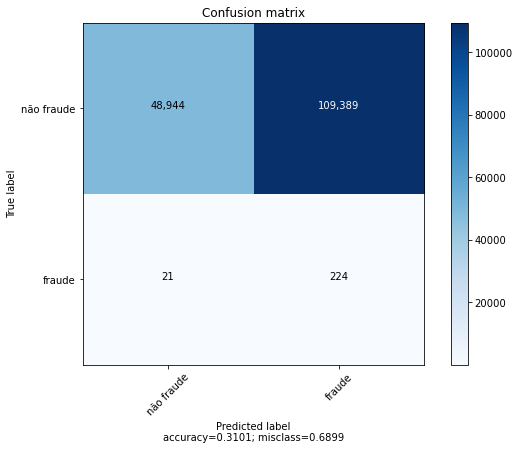

In [29]:
plot_confusion_matrix(m.confusion_matrix(y_test_X2, y_pred),
                          ['não fraude','fraude'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)